In [1]:
# define logging and working directory
from ProjectRoot import change_wd_to_project_root
change_wd_to_project_root()
from src.utils.notebook_imports import *
from pyforest import *
from src.utils.Tensorflow_helper import choose_gpu_by_id
from tensorflow.keras.utils import plot_model

# define GPU id to use
GPU_IDS = '0,1'
GPUS = choose_gpu_by_id(GPU_IDS)
print(GPUS)

# jupyter magic config
%matplotlib inline
%reload_ext autoreload
%autoreload 2

# import helpers
from src.utils.utils_io import Console_and_file_logger, init_config
from src.visualization.Visualize import show_2D_or_3D
from src.data.Dataset import get_img_msk_files_from_split_dir, load_acdc_files, get_train_data_from_df, get_trainings_files
from src.data.Generators import DataGenerator, get_samples
#from src.utils.unet_3d_metrics import weighted_dice_coefficient_loss
from src.utils.KerasCallbacks import get_callbacks
import src.utils.my_metrics as metr
import cv2
from tensorflow.keras.losses import mse
import src.utils.my_metrics as metr


# define experiment name for report, model and log paths + filenames
#EXPERIMENT = '2D/tf2/acdc/combined/2D_NOrot90_dfsplit_6_224_11_fold1'
EXPERIMENT = '3D/ax_sax/st_unet_ax_and_sax/temp'
now = datetime.datetime.now()
# image params, change for different input data/architecture
ARCHITECTURE = '3D' # 2D
# path params
DATASET = 'GCN'  # 'acdc' # or 'gcn'
TRAIN_PATH = 'data/raw/{}/{}/train/'.format(DATASET, ARCHITECTURE)
VAL_PATH = 'data/raw/{}/{}/val/'.format(DATASET, ARCHITECTURE)
TEST_PATH = 'data/raw/{}/{}/val/'.format(DATASET, ARCHITECTURE)
#DF_DATA_PATH = 'data/raw/{}/{}/df_kfold.csv'.format(DATASET, ARCHITECTURE)
#DF_DATA_PATH = 'data/raw/miccai2020/2d_dataset.csv' # miccai special case
DATA_PATH = '/mnt/data/git/cardio/data/raw/gcn_05_2020_ax_sax_86/AX_3D_ISO/'
FOLD = 0

MODEL_PATH = os.path.join('models', EXPERIMENT, str(now.strftime("%Y-%m-%d_%H_%M")))
TENSORBOARD_LOG_DIR = os.path.join('reports/tensorboard_logs', EXPERIMENT,str(now.strftime("%Y-%m-%d_%H_%M")))
CONFIG_PATH = os.path.join('reports/configs/',EXPERIMENT,str(now.strftime("%Y-%m-%d_%H_%M")))
HISTORY_PATH = os.path.join('reports/history/',EXPERIMENT,str(now.strftime("%Y-%m-%d_%H_%M")))

DIM = [32,64, 64] # network input params for spacing of 5
#DIM = [80, 224, 224]
DEPTH = 4 # number of down-/upsampling blocks
FILTERS = 32 # initial number of filters, will be doubled after each downsampling block
#SPACING = [8,1.1, 1,1] # used by sitk, order will be reversed to have the same shape as dim
SPACING = [5,5, 5] # if resample, resample to this spacing
M_POOL = [2, 2, 2]# used for downsampling and upsampling
F_SIZE = [3, 3, 3] # conv filter size
IMG_CHANNELS = 1
MASK_VALUES = [0, 1, 2, 3]  #channel order: Background, RV, MYO, LV
MASK_CLASSES = len(MASK_VALUES) # no of labels
BORDER_MODE = cv2.BORDER_REFLECT_101
IMG_INTERPOLATION = cv2.INTER_LINEAR
MSK_INTERPOLATION = cv2.INTER_NEAREST
AUGMENT = False
SHUFFLE = True
AUGMENT_GRID = False
RESAMPLE = True
SCALER = 'MinMax' # MinMax Standard or Robust

# training params
#GENERATOR_WORKER = 6# if not set, use batchsize
SEED = 42 # define a seed for the generator shuffle
BATCHSIZE = 16 # 32, 64, 24, 16, 1 for 3D use: 8
INITIAL_EPOCH = 0 # change this to continue training
EPOCHS = 300 # define a maximum numbers of epochs
EPOCHS_BETWEEN_CHECKPOINTS = 5
MONITOR_FUNCTION = 'loss'
MONITOR_MODE = 'min'
SAVE_MODEL_FUNCTION = 'loss'
SAVE_MODEL_MODE = 'min'
BN_FIRST = False # decide if BN between Conv and activation or afterwards
BATCH_NORMALISATION = True # apply BN or not
USE_UPSAMPLE = True # otherwise use transpose
PAD = 'same' # padding strategy
KERNEL_INIT = 'he_normal' # conv weight initialisation
OPTIMIZER = 'adam' # Adam, Adagrad, RMSprop, Adadelta,  # https://keras.io/optimizers/
ACTIVATION = 'elu' # tf.keras.layers.LeakyReLU(), relu, any non linear activation function
LEARNING_RATE = 1e-2 # start with a huge lr to converge fast
DECAY_FACTOR = 0.3 # Define a learning rate decay for the ReduceLROnPlateau callback
MIN_LR = 1e-10 # smaller lr does not improve the model
DROPOUT_min = 0.3 # lower dropout at the shallow layers
DROPOUT_max = 0.5 # higher dropout at the deep layers

metrics = [
    metr.dice_coef_labels,
    metr.dice_coef_myo,
    metr.dice_coef_lv,
    metr.dice_coef_rv
]

#MASKING_VALUES = [2]
#MASKING_IMAGE = False

LOSS_FUNCTION = metr.bce_dice_loss
#LOSS_FUNCTION = metr.jaccard_distance_loss
#LOSS_FUNCTION = metr.bce_dice_jac_loss

Console_and_file_logger(EXPERIMENT, logging.INFO)

# Define a config for param injection,
# save a serialized version, 
# make sure all paths exist
config = init_config(config=locals(), save=True)
print(config)

search for root_dir and set working directory
Working directory set to: /mnt/data/git/cardio


Using TensorFlow backend.
2020-07-06 12:44:23,163 INFO -------------------- Start --------------------
2020-07-06 12:44:23,163 INFO Working directory: /mnt/data/git/cardio.
2020-07-06 12:44:23,163 INFO Log file: ./logs/3D/ax_sax/st_unet_ax_and_sax/temp.log
2020-07-06 12:44:23,163 INFO Log level for console: INFO


['/gpu:0', '/gpu:1']
{'GPU_IDS': '0,1', 'GPUS': ['/gpu:0', '/gpu:1'], 'EXPERIMENT': '3D/ax_sax/st_unet_ax_and_sax/temp', 'ARCHITECTURE': '3D', 'DATASET': 'GCN', 'TRAIN_PATH': 'data/raw/GCN/3D/train/', 'VAL_PATH': 'data/raw/GCN/3D/val/', 'TEST_PATH': 'data/raw/GCN/3D/val/', 'DATA_PATH': '/mnt/data/git/cardio/data/raw/gcn_05_2020_ax_sax_86/AX_3D_ISO/', 'FOLD': 0, 'MODEL_PATH': 'models/3D/ax_sax/st_unet_ax_and_sax/temp/2020-07-06_12_44', 'TENSORBOARD_LOG_DIR': 'reports/tensorboard_logs/3D/ax_sax/st_unet_ax_and_sax/temp/2020-07-06_12_44', 'CONFIG_PATH': 'reports/configs/3D/ax_sax/st_unet_ax_and_sax/temp/2020-07-06_12_44', 'HISTORY_PATH': 'reports/history/3D/ax_sax/st_unet_ax_and_sax/temp/2020-07-06_12_44', 'DIM': [32, 64, 64], 'DEPTH': 4, 'FILTERS': 32, 'SPACING': [5, 5, 5], 'M_POOL': [2, 2, 2], 'F_SIZE': [3, 3, 3], 'IMG_CHANNELS': 1, 'MASK_VALUES': [0, 1, 2, 3], 'MASK_CLASSES': 4, 'BORDER_MODE': 4, 'IMG_INTERPOLATION': 1, 'MSK_INTERPOLATION': 0, 'AUGMENT': False, 'SHUFFLE': True, 'AUGMENT

In [2]:
# Load AX slices

from src.data.Generators import MotionDataGenerator, CycleMotionDataGenerator, SpatialUnetDataGenerator
info = {}

x_train_ax, y_train_ax, x_val_ax, y_val_ax =  get_trainings_files(data_path=DATA_PATH,fold=FOLD)
config.update(info)
config = init_config(config)

logging.info('x_train files: {}, y_train files: {}'.format(len(x_train_ax), len(y_train_ax)))
logging.info('x_val files: {}, y_val files: {}'.format(len(x_val_ax), len(y_val_ax)))

2020-07-06 12:44:25,693 INFO Found 162 images/masks in /mnt/data/git/cardio/data/raw/gcn_05_2020_ax_sax_86/AX_3D_ISO/
2020-07-06 12:44:25,698 INFO Selected 120 of 162 files with 64 of 86 patients for training fold 0
2020-07-06 12:44:25,699 INFO x_train files: 120, y_train files: 120
2020-07-06 12:44:25,700 INFO x_val files: 42, y_val files: 42


In [3]:
# load SAX slices
DATA_PATH_SAX = DATA_PATH.replace('AX_3D_ISO', 'SAX_3D_ISO')
#DATA_PATH_SAX = 'data/interim/sax_ax_3d_thres_50_max/ax_to_sax'
x_train_sax, y_train_sax, x_val_sax, y_val_sax =  get_trainings_files(data_path=DATA_PATH_SAX,fold=FOLD)
config.update(info)
config = init_config(config)

logging.info('x_train files: {}, y_train files: {}'.format(len(x_train_sax), len(y_train_sax)))
logging.info('x_val files: {}, y_val files: {}'.format(len(x_val_sax), len(y_val_sax)))

2020-07-06 12:44:26,092 INFO Found 162 images/masks in /mnt/data/git/cardio/data/raw/gcn_05_2020_ax_sax_86/SAX_3D_ISO/
2020-07-06 12:44:26,098 INFO Selected 120 of 162 files with 64 of 86 patients for training fold 0
2020-07-06 12:44:26,098 INFO x_train files: 120, y_train files: 120
2020-07-06 12:44:26,099 INFO x_val files: 42, y_val files: 42


In [4]:
print('ax examples: {}'.format(x_train_ax[:2]))
print('sax_examples: {}'.format(x_train_sax[:2]))

ax examples: ['/mnt/data/git/cardio/data/raw/gcn_05_2020_ax_sax_86/AX_3D_ISO/0000-0PTV75MP_2005-06-27_ED_img.nrrd', '/mnt/data/git/cardio/data/raw/gcn_05_2020_ax_sax_86/AX_3D_ISO/0000-0PTV75MP_2005-06-27_ES_img.nrrd']
sax_examples: ['/mnt/data/git/cardio/data/raw/gcn_05_2020_ax_sax_86/SAX_3D_ISO/0000-0PTV75MP_2005-06-27_ED_img.nrrd', '/mnt/data/git/cardio/data/raw/gcn_05_2020_ax_sax_86/SAX_3D_ISO/0000-0PTV75MP_2005-06-27_ES_img.nrrd']


In [5]:
# filter files by name
#x_train_ax = [x for x in x_train_ax if 'CT8YR38C_2005' in x]
#print(len(x_train_ax))
#x_train_sax = [x for x in x_train_sax if 'CT8YR38C_2005' in x]

In [6]:
Console_and_file_logger('temp', logging.INFO)
batch_generator = SpatialUnetDataGenerator(x_train_ax + x_train_sax, y_train_ax + y_train_sax, config)

2020-07-06 12:44:28,459 INFO -------------------- Start --------------------
2020-07-06 12:44:28,460 INFO Working directory: /mnt/data/git/cardio.
2020-07-06 12:44:28,460 INFO Log file: ./logs/temp.log
2020-07-06 12:44:28,461 INFO Log level for console: INFO
2020-07-06 12:44:28,461 INFO Create DataGenerator
2020-07-06 12:44:28,463 INFO Datagenerator created with: 
 shape: [32, 64, 64]
 spacing: [5, 5, 5]
 batchsize: 16
 Scaler: MinMax
 Images: 240 
 Augment_grid: False 
 Thread workers: 16
2020-07-06 12:44:28,463 INFO No augmentation


In [7]:
# Select batch generator output
@interact
def select_batch(batch = (0,len(batch_generator), 1)):
    global x, y
    input_ , output_ = batch_generator.__getitem__(batch)
    x = input_[0]
    y = output_[0]
    m = output_[2]
    logging.info('input image: {}'.format(x.shape))
    logging.info('pred mask: {}'.format(y.shape))
    logging.info('transformation matrix: {}'.format(m.shape))

interactive(children=(IntSlider(value=7, description='batch', max=15), Output()), _dom_classes=('widget-intera…

In [8]:
@interact
def select_image_in_batch(im = (0,x.shape[0]- 1, 1),slice_by=(1,8)):
    
    # define a different logging level to make the generator steps visible
    logging.getLogger().setLevel(logging.DEBUG)
    #show_2D_or_3D(x[im][...,0][::5])
    logging.info(x[im].shape)
    show_2D_or_3D(x[im][...,0][::slice_by])
    plt.savefig('reports/images/temp/ax.pdf')
    plt.show()
    logging.info(y[im].shape)
    show_2D_or_3D(y[im][::slice_by])
    plt.savefig('reports/images/temp/sax.pdf')
    plt.show()
    

interactive(children=(IntSlider(value=7, description='im', max=15), IntSlider(value=4, description='slice_by',…

In [9]:
import src.models.SpatialTransformer as st
from src.models.SpatialTransformer import create_affine_transformer, create_affine_cycle_transformer

using tensorflow, need to monkey patch
tf.python.backend.slice overwritten by monkey patch


In [16]:
if 'strategy' in locals():
    pass
else:
    print('create a new strategy')
    # distribute the training with the mirrored data paradigm across multiple gpus if available, if not use gpu 0
    strategy = tf.distribute.MirroredStrategy(devices=config.get('GPUS', ["/gpu:0"]))
with strategy.scope():
    model = st.create_spatial_unet(config=config, metrics=metrics, unet_2d=None)

(None, 32, 64, 64, 1)


In [17]:
model.summary()

Model: "enc_st_unet_st"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 32, 64, 64, 1)]   0         
_________________________________________________________________
trainable_3D_unet (Functiona (None, 32, 64, 64, 4)     25894724  
Total params: 25,894,724
Trainable params: 25,888,836
Non-trainable params: 5,888
_________________________________________________________________


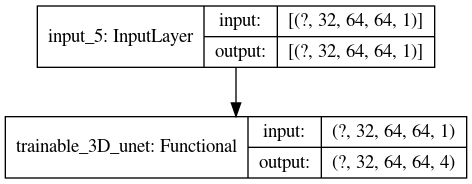

In [18]:
plot_model(model, to_file='data/temp/graph.png',show_shapes=True)

In [20]:
# predictions of the untrained model on the current generator
@interact
def select_image_in_batch(im = (0,x.shape[0]- 1, 1),slice_by=(1,11)):
    global m
    temp = x[im]
    temp_ = y[im]
    # define a different logging level to make the generator steps visible
    logging.getLogger().setLevel(logging.INFO)
    logging.info('prediction on: {}'.format(temp.shape))
    show_2D_or_3D(temp[::slice_by])
    plt.show()
    pred = model.predict(np.expand_dims(temp,axis=0))
    logging.info('max: {}'.format(pred[0][::slice_by].max()))
    logging.info('predicted masks of the model: {}'.format(pred[0].shape))
    show_2D_or_3D(temp[::slice_by], pred[0][::slice_by])
    plt.show()
    """logging.info('internal repr of the input image: {}'.format(inv.shape))
    show_2D_or_3D(inv[0][::slice_by])
    plt.show()"""
    logging.info('target mask: {}'.format(temp_.shape))
    show_2D_or_3D(temp[::slice_by], temp_[::slice_by])
    plt.show()
    logging.info('MSE: {}'.format(mse(pred[0], temp_).numpy().mean()))
    logging.info('MSE center cube: {}'.format(metr.cubic_center_loss_wrapper(pred[0], temp_).numpy().mean()))
    try:
        print(np.reshape(m[0],(3,4)))
    except Exception as e:
        pass

interactive(children=(IntSlider(value=7, description='im', max=15), IntSlider(value=6, description='slice_by',…

In [ ]:
from src.models.Unets import get_optimizer
model.compile(optimizer=get_optimizer(config, 'finetune'),
                      loss={'warped': metr.front_mse, 'cycle_warped': 'mse' },
                      loss_weights={'warped': 1.0, 'cycle_warped': 0.1})

In [19]:
# train one model
initial_epoch = 0
# training

# start a new main process for this training to free gpu memory afterwards
logging.info('Fit model, start trainings process')
# fit model with trainingsgenerator
results = model.fit(
    x=batch_generator,
    epochs=400,
    callbacks = get_callbacks(config),
    steps_per_epoch = len(batch_generator),
    initial_epoch=initial_epoch,
    max_queue_size=6,
    workers=8,
    #use_multiprocessing=True,
    verbose=1)

2020-07-03 13:03:08,342 INFO Fit model, start trainings process


Epoch 1/400


2020-07-03 13:03:11,820 INFO batch_all_reduce: 82 all-reduces with algorithm = nccl, num_packs = 1
2020-07-03 13:03:14,954 INFO batch_all_reduce: 82 all-reduces with algorithm = nccl, num_packs = 1


 1/15 [=>............................] - ETA: 0s - loss: 0.1662

2020-07-03 13:03:28,536 WARNING From /home/sven/anaconda3/envs/tf2/lib/python3.6/site-packages/tensorflow/python/ops/summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.


15/15 [==============================] - ETA: 0s - loss: 0.0401

2020-07-03 13:03:35,493 INFO Saved model to disk: models/3D/ax_sax/st_unet_ax_and_sax/temp/2020-07-03_13_01



Epoch 00001: loss improved from inf to 0.04008, saving model to models/3D/ax_sax/st_unet_ax_and_sax/temp/2020-07-03_13_01/checkpoint.h5
15/15 [==============================] - 11s 763ms/step - loss: 0.0401 - lr: 0.0100
Epoch 2/400
15/15 [==============================] - ETA: 0s - loss: -0.1716
Epoch 00002: loss improved from 0.04008 to -0.17164, saving model to models/3D/ax_sax/st_unet_ax_and_sax/temp/2020-07-03_13_01/checkpoint.h5
15/15 [==============================] - 12s 822ms/step - loss: -0.1716 - lr: 0.0100
Epoch 3/400
15/15 [==============================] - ETA: 0s - loss: -0.3745
Epoch 00003: loss improved from -0.17164 to -0.37452, saving model to models/3D/ax_sax/st_unet_ax_and_sax/temp/2020-07-03_13_01/checkpoint.h5
15/15 [==============================] - 12s 831ms/step - loss: -0.3745 - lr: 0.0100
Epoch 4/400
15/15 [==============================] - ETA: 0s - loss: -0.4534
Epoch 00004: loss improved from -0.37452 to -0.45338, saving model to models/3D/ax_sax/st_unet_

In [ ]:
# load pre-trained AXtoSAX rotation model

"""
load past config for model training 
"""
if tf.distribute.get_strategy():
    strategy = tf.distribute.get_strategy()
else:
    # distribute the training with the mirrored data paradigm across multiple gpus if available, if not use gpu 0
    strategy = tf.distribute.MirroredStrategy(devices=config.get('GPUS', ["/gpu:0"]))
tf.print('Number of devices: {}'.format(strategy.num_replicas_in_sync))
# trained on the full volume, finetuned on firt 20 slices with a margin of 50 (cube mse loss), start looks good, some mistakes are still there
config_file  = 'reports/configs/3D/ax_sax/motion_ax_to_sax/isotrop_finetune_topbottom/2020-06-29_18_02/config.json'
#config_file = 'reports/configs/2D/acdc/cv/fold3/2020-05-12_22_54/config.json'
load = True # change to false, if this pipeline is used without finetuning
# load config with all params into global namespace
from src.models.Unets import load_pretrained_model
if load: # load pretrained model
    with open(config_file, encoding='utf-8') as data_file:
        config_temp = json.loads(data_file.read())
    config_temp['LOSS_FUNCTION'] = config['LOSS_FUNCTION']
    logging.info('Load model from Experiment: {}'.format(config_temp['EXPERIMENT']))
    #logging.info('config:\n {}'.format(json.dumps(config, indent=4, sort_keys=True)))

    try:
        with strategy.scope():
            globals()['model'] = load_pretrained_model(config_temp, metrics, comp=False,multigpu=False, transformer=True)
            #model.summary()
    except Exception as e:
        logging.error(str(e))

# Fast predictions with all files of the generator

In [25]:
from src.utils.my_metrics import front_mse as cube_loss
cfg = config.copy()
cfg['BATCHSIZE'] = 10
valid_generator = SpatialUnetDataGenerator(x_val_ax + x_val_sax, y_val_ax + y_val_sax, config)
#valid_generator = MotionDataGenerator(x_train_ax, x_train_sax, cfg)
input_, output_ = valid_generator.__getitem__(0)
x_ = input_[0]
y_ = output_[0]
@interact
def select_image_in_batch(im = (0,x_.shape[0]- 1, 1), slice_by=(1,10)):
    global m
    temp = x_[im]
    temp_ = y_[im]
    # define a different logging level to make the generator steps visible
    logging.getLogger().setLevel(logging.INFO)
    logging.info('prediction on:')
    show_2D_or_3D(temp[::slice_by])
    plt.show()
    logging.info('predicted by the model')
    pred = model.predict(np.expand_dims(temp,axis=0))
    show_2D_or_3D(temp[::slice_by],pred[0][::slice_by])
    plt.show()
    logging.info('target (SAX):')
    show_2D_or_3D(temp[::slice_by],temp_[::slice_by])
    plt.show()
    """logging.info('inverted rotation')
    show_2D_or_3D(inv[0][::slice_by])
    plt.show()"""
    z_margin = 10
    inplane_margin = 10
    y_true = temp_
    y_pred = pred[0]
    y_true = y_true[:z_margin, inplane_margin: -inplane_margin, inplane_margin:-inplane_margin,:]
    y_pred = y_pred[:z_margin, inplane_margin: -inplane_margin, inplane_margin:-inplane_margin,:]
    print('cropped volumes by the loss')
    show_2D_or_3D(y_pred)
    plt.show()
    show_2D_or_3D(y_true)
    plt.show()
    
    print(y_true.shape)
    print(y_pred.shape)
    print('MSE: {}'.format(mse(temp_, pred[0]).numpy().mean()))
    print('MSE center cube: {}'.format(cube_loss(temp_, pred[0]).numpy().mean()))
    try:
        print(np.reshape(m[0],(3,4)))
    except Exception as e:
        pass

2020-07-06 09:44:54,339 INFO Create DataGenerator
2020-07-06 09:44:54,341 INFO Datagenerator created with: 
 shape: [32, 64, 64]
 spacing: [5, 5, 5]
 batchsize: 16
 Scaler: MinMax
 Images: 84 
 Augment_grid: False 
 Thread workers: 16
2020-07-06 09:44:54,341 INFO No augmentation


interactive(children=(IntSlider(value=7, description='im', max=15), IntSlider(value=5, description='slice_by',…

# Predictions on the heldout test split

In [21]:
cfg = config.copy()
cfg['BATCHSIZE'] = len(x_val_ax)
v_generator = MotionDataGenerator(x_val_ax, x_val_sax, cfg)
input_, output_ = v_generator.__getitem__(0)
x_ = input_[0]
y_ = output_[0]
@interact
def select_image_in_batch(im = (0,x_.shape[0]- 1, 1), slice_by=(1,11)):
    global m
    temp = x_[im]
    temp_ = y_[im]
    # define a different logging level to make the generator steps visible
    logging.getLogger().setLevel(logging.INFO)
    logging.info('prediction on:')
    show_2D_or_3D(temp[::slice_by])
    plt.show()
    logging.info('rotated by the model')
    pred = model.predict(np.expand_dims(temp,axis=0))
    show_2D_or_3D(pred[0][::slice_by])
    plt.show()
    logging.info('target (SAX):')
    show_2D_or_3D(temp_[::slice_by])
    plt.show()
    print('MSE: {}'.format(mse(pred[0], temp_).numpy().mean()))
    print('MSE center cube: {}'.format(metr.cubic_center_loss_wrapper(pred[0], temp_).numpy().mean()))
    try:
        print(np.reshape(m[0],(3,4)))
    except Exception as e:
        pass

2020-07-06 09:30:45,085 INFO Create DataGenerator
2020-07-06 09:30:45,086 INFO Datagenerator created with: 
 shape: [32, 64, 64]
 spacing: [5, 5, 5]
 batchsize: 42
 Scaler: MinMax
 Images: 42 
 Augment_grid: False 
 Thread workers: 32
2020-07-06 09:30:45,087 INFO No augmentation


interactive(children=(IntSlider(value=20, description='im', max=41), IntSlider(value=6, description='slice_by'…

## 1. AX and SAX volumes 

Create a MotionDatagenerator from the heldout test split without shuffle and batchsize == len(files)

## 2. AX images and AX masks

Create a Datagenerator from AX image and mask files, both will be used in the next cell for the prediction pipeline

In [ ]:
# create a motion generator with the val files without shuffle for sorted predictions
from src.models.SpatialTransformer import create_affine_transformer_fixed
from src.data.Preprocess import from_channel_to_flat, transform_to_binary_mask
from src.data.Postprocess import clean_3d_prediction_3d_cc
import shutil
from src.data.Dataset import copy_meta_and_save
cfg = config.copy()
cfg['BATCHSIZE'] = len(x_val_ax)
cfg['SHUFFLE'] = False
v_generator = MotionDataGenerator(x_val_ax, x_val_sax, cfg)
input_, output_ = v_generator.__getitem__(0)
x_ = input_[0]
y_ = output_[0]
msk_cfg = cfg.copy()
msk_cfg['IMG_CHANNELS'] = 1
v_msk_generator = DataGenerator(x_val_ax, y_val_ax, msk_cfg)
__, ax_msk_ = v_msk_generator.__getitem__(0)


## Predict AXtoSAX rotation, predict SAX Segmentation, rotate the mask reverse (SAXtoAX) by the predicted inverse
Complete pipeline:
1. AX_isotrop, 
2. Motion-generator which center crops or resize (needs to be changed) in plane, crop and pad in Z  to align to the network shape, no further resampling
3. Rotated into SAX domain by the trained Spatial-Transformer + Encoder (trained on the trainings split)
4. Mask prediction with a 3D Wrapper, fed with a pre-trained 2D unet (traind on fold1 from the improved SPIE pipeline)
5. Connected Component filtering & binarizing with a threshold of 0.5
6. Label-wise transformation of the mask back into the AX domain (with linear interpolation) inverted matrix from 3.
7. Second Connected Component Filtering (need to be checked if really necessary)
8. Copied the dicom metadata, direction and origin from the original AX_isotrop file to the predicted mask, the input AX image, and the AX GT mask, saved all three files
9. Evaluated 3D metrics on the Pred and GT 3D Masks, both files have a spacing of (1.5,1.5,1.5) and a size of 80,224,224 (better would be to use the AX_isotrop mask before the generator, therefore the generator steps need to be inverted, in some very few cases we resize here which is an nearest neighbor interpolation on the GT mask. This step could be changed to padding, but was kept to resize to align with the trainings preprocessing of the unet)

In [ ]:
@interact
def select_image_in_batch(im=(0, x_.shape[0] - 1, 1), 
                          slice_n=(1, 11), 
                          export_path='data/predicted/temp/',
                          shift_z=20,
                          debug=False,
                         save=False):
    """
    Use the spatial transformer to rotate, predict segmentations, reverse the rotation on the masks and save the nrrd files (image, gt and pred)
    :param im: slider to select another image from the generator
    :param slice_n: The show_2D_3D method slices to a maximum of 20 slices in z, this parameter allows to further slice the visualisations
    :param export_path: path to save the img, gt and prediction volumes as nrrd file, the file names will be the same as in x_ax_val...
    :param debug: bool to enable plotting of the intermediate steps
    :return: void
    """
    global m

    full_file_name = y_val_ax[im]
    filename = os.path.basename(full_file_name)
    logging.info(filename)
    temp = x_[im]
    temp_ = y_[im]
    # define a different logging level to make the generator steps visible
    logging.getLogger().setLevel(logging.INFO)
    logging.info('Prediction on AX volume:')
    if debug: show_2D_or_3D(temp[::slice_n])
    plt.show()
    
    # Predict rotation of AX and get transformation matrix
    logging.info('AX --> SAX rotated by the model')
    pred, m = model.predict(np.expand_dims(temp, axis=0))
    if debug: show_2D_or_3D(pred[0][::slice_n])
    plt.show()
    
    # make copy of m for reusage
    m_ = m.copy()
    
    # Repeat the transformation increase the z translation manually
    #z_shift = m_[0][-1]
    #m_[0][-1] += shift_z
    #logging.info('Repeat the transformation - extend the Z-translation from {} to {}'.format(z_shift, m_[0][-1]))
    #logging.getLogger().setLevel(logging.ERROR)
    transformer = create_affine_transformer_fixed(config=config, interp_method='linear')
    #pred, m = transformer.predict(x=[np.expand_dims(temp, axis=0), m_])
    #if debug: show_2D_or_3D(pred[0][::slice_n])
    #plt.show()
    
    # reshape m to matrix
    m = np.reshape(m, (3, 4))

    # create a square ident matrix slice m into it
    m_matrix = np.identity(4)
    # slice m (3,4) into identity (4,4)
    m_matrix[:3, :] = m
    # calc inverse, flatten the matrix and cut off the last row for the spatial transformer
    m_matrix_inverse = np.linalg.inv(m_matrix)
    m_matrix_inverse_flatten = m_matrix_inverse.flatten()[:-4]

    # show the target AXtoSAX volume
    logging.info('Target (SAX):')
    if debug: show_2D_or_3D(temp_[::slice_n])
    plt.show()

    # apply the inverse to our AXtoSAX volume
    logging.getLogger().setLevel(logging.INFO)
    logging.info('Apply the invers rotation to our AXtoSAX')
    logging.getLogger().setLevel(logging.ERROR)
    inv, _ = transformer.predict(x=[pred, np.expand_dims(m_matrix_inverse_flatten, axis=0)])
    #if debug: show_2D_or_3D(inv[0][::slice_n])
    plt.show()

    # load a 3D wrapper model for segmenting the new SAX
    if 'unet' in globals():
        msk = unet.predict(x=pred)
        msk = clean_3d_prediction_3d_cc(from_channel_to_flat(msk[0] >= 0.5))
        msk = transform_to_binary_mask(msk)
        logging.getLogger().setLevel(logging.INFO)
        logging.info('Predicted mask')
        if debug: show_2D_or_3D(pred[0][::slice_n], msk[::slice_n])
        plt.show()

        # apply inverse to our msk and plot it together with the inverse AXtoSAX
        logging.getLogger().setLevel(logging.ERROR)
        m_transformer = create_affine_transformer_fixed(config=config, interp_method='nearest')
        inv_msk = list()
        for c in range(msk.shape[-1]):
            inv_m, _ = m_transformer.predict(
                x=[np.expand_dims(msk[..., c], axis=0), np.expand_dims(m_matrix_inverse_flatten, axis=0)])
            inv_msk.append(inv_m[..., 0] >= 0.5)
        inv_msk = np.stack(inv_msk, axis=-1)
        logging.getLogger().setLevel(logging.INFO)
        logging.info('Predicted mask rotated to AX on inverse AXtoSAX')
        if debug: show_2D_or_3D(inv[0][::slice_n], inv_msk[0][::slice_n])
        plt.show()
        logging.info('Predicted mask rotated to AX on original AX image')
        show_2D_or_3D(temp[::slice_n], inv_msk[0][::slice_n])
        plt.show()
        
        # get the AX target segmentation, processed by the generator to have it in the same shape
        msk_gt_raw = ax_msk_[im]
        msk_flatten = clean_3d_prediction_3d_cc(from_channel_to_flat(inv_msk[0]))
        msk_gt_flatten = from_channel_to_flat(msk_gt_raw)
        logging.info('GT on AX')
        show_2D_or_3D(temp[::slice_n], msk_gt_flatten[::slice_n])
        plt.show()
        
        # create a nrrd file for the gt, pred and image volume
        sitk_pred = sitk.GetImageFromArray(msk_flatten)
        sitk_ax_img = sitk.GetImageFromArray(temp)
        sitk_ax_msk = sitk.GetImageFromArray(msk_gt_flatten)

        ensure_dir(os.path.join(export_path, 'pred'))
        ensure_dir(os.path.join(export_path, 'image'))
        ensure_dir(os.path.join(export_path, 'gt'))
        
        # load a reference nrrd file, copy all metadata and save the volumes
        reference_sitk = sitk.ReadImage(full_file_name)
        if save:
            copy_meta_and_save(sitk_pred, reference_sitk, os.path.join(export_path, 'pred', filename))
            copy_meta_and_save(sitk_ax_img, reference_sitk,os.path.join(export_path, 'image', filename.replace('msk', 'img')))
            copy_meta_and_save(sitk_ax_msk, reference_sitk, os.path.join(export_path, 'gt', filename))
        # shutil.copyfile(full_file_name, os.path.join(export_path, 'gt', filename))
    else:
        logging.info('no unet in global namespace, segmentation is not possible')

    logging.info('MSE: {}'.format(mse(pred[0], temp_).numpy().mean()))
    logging.info('MSE center cube: {}'.format(metr.cubic_center_loss_wrapper(pred[0], temp_).numpy().mean()))
    try:
        print(np.reshape(m[0], (3, 4)))
    except Exception as e:
        pass


In [ ]:
shift_z = 10
path_ = 'data/predicted/AX_to_SAX_to_AX_finetune_first20z_margin_50/3D/'
for i in range(x_.shape[0]):
    select_image_in_batch(im=i,slice_n=5, debug=False,shift_z=shift_z, export_path=path_, save=True)

In [ ]:
# check the memory usage
import sys

# These are the usual ipython objects, including this one you are creating
ipython_vars = ['In', 'Out', 'exit', 'quit', 'get_ipython', 'ipython_vars']

# Get a sorted list of the objects and their sizes
sorted([(x, sys.getsizeof(globals().get(x))) for x in dir() if not x.startswith('_') and x not in sys.modules and x not in ipython_vars], key=lambda x: x[1], reverse=True)

In [ ]:
# Load a previous config and by this a pre-trained model
from ipyfilechooser import FileChooser
config_chooser = FileChooser(os.path.join(os.getcwd(),'reports/configs'), 'config.json')
display(config_chooser) # 3D/wrapper/fold1/last

In [ ]:
"""
load past config for model training 
"""

strategy = tf.distribute.MirroredStrategy(devices=config.get('GPUS', ["/gpu:0"]))
if strategy:
    pass
else:
    print('creating new strategy')
    # distribute the training with the mirrored data paradigm across multiple gpus if available, if not use gpu 0
    strategy = tf.distribute.MirroredStrategy(devices=config.get('GPUS', ["/gpu:0"]))
if config_chooser:
    config_file  = config_chooser.selected
#config_file = 'reports/configs/2D/acdc/cv/fold3/2020-05-12_22_54/config.json'
load = True # change to false, if this pipeline is used without finetuning
# load config with all params into global namespace
from src.models.Unets import load_pretrained_model
if load: # load pretrained model
    with open(config_file, encoding='utf-8') as data_file:
        config_temp = json.loads(data_file.read())
    config_temp['LOSS_FUNCTION'] = config['LOSS_FUNCTION']
    logging.info('Load model from Experiment: {}'.format(config_temp['EXPERIMENT']))
    #logging.info('config:\n {}'.format(json.dumps(config, indent=4, sort_keys=True)))
    try:
        with strategy.scope():
            globals()['unet'] = load_pretrained_model(config_temp, metrics, comp=False,multigpu=False)
            globals()['unet'].summary()
    except Exception as e:
        logging.error(str(e))